#**Capstone project: Can ML Outperform Market-Neutral Trading in Structural Breaks?**

**Note:**

It's always a good practise to "restart the session", whenever changes are made to github repository


##**Step 1:** GitHub setup

1) Clone/Update the projects github repository

In [1]:
# Use for the first time to clone the github repo or when the repo is updated
%rm -rf /content/MarketNeutral_Trading/
%cd /content
!git clone https://github.com/WQU-Capstone-11205/MarketNeutral_Trading.git
%cd /content/MarketNeutral_Trading

/content
Cloning into 'MarketNeutral_Trading'...
remote: Enumerating objects: 1142, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 1142 (delta 113), reused 5 (delta 5), pack-reused 953 (from 3)
Receiving objects: 100% (1142/1142), 3.05 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (644/644), done.
/content/MarketNeutral_Trading


2) Add the project's github repository's path to the system path

In [2]:
import sys
sys.path.append('/content/MarketNeutral_Trading')

3) Install projects required packages

In [3]:
!pip install -r requirements.txt

In [4]:
import warnings
warnings.filterwarnings('ignore')

##**Step 2:** Data loading

Load data and bechmark_strategy data

In [5]:
from data_loading.fetch_data import fetch_from_yfinance
from data_loading.distance_spread import distance_spread
from util.ff_benchmark import get_ff_benchmark_returns

# Example pair: XLF and FAS (Financial sector ETFs, often cointegrated)
ticker1 = 'XLF'
ticker2 = 'FAS'# Note: FAS is a leveraged ETF, may require careful handling/interpretation
start_date = '2005-01-01' #'2015-01-01'
end_date = '2025-01-01' # '2025-01-01'
# Use an in-sample period for training the cointegration relationship
in_sample_cutoff_date = '2017-01-01'

data = fetch_from_yfinance([ticker1, ticker2], start_date, end_date)
train_data = data.loc[:in_sample_cutoff_date]
test_data = data.loc[in_sample_cutoff_date:]

spread = distance_spread([ticker1, ticker2], start_date=start_date, end_date=end_date)
train_spread = spread.loc[:in_sample_cutoff_date]
test_spread = spread.loc[in_sample_cutoff_date:]

# Fetch a benchmark for alpha/beta calculation (e.g., SPY)
benchmark_data = fetch_from_yfinance(['SPY'], start_date, end_date)
ff_benchmark_returns = get_ff_benchmark_returns(in_sample_cutoff_date, end_date)
benchmark_returns = benchmark_data.pct_change().dropna()
test_spy_returns = benchmark_returns[in_sample_cutoff_date:]

test_data_returns = test_data.pct_change().dropna()


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed


##**Step 3:** Check Cointegration and Hedge ratio


In [6]:
from metrics.stats import check_cointegration_and_hedge_ratio

beta, coint_spread = check_cointegration_and_hedge_ratio(train_data[ticker1], train_data[ticker2])

print(f"Beta: {round(beta, 4)}")


Pair is cointegrated with p-value 0.0014. Hedge ratio (beta): 2.3761
Beta: 2.3761


##**Step 4:** Backtest the strategy for Cointegration spread and calculate performance metrics on out of sample data

In [7]:
from trad_arbt_strat.cointegration_trading import cointegration_trading
import numpy as np
from metrics.stats import sharpe_ratio, compute_max_drawdown, sortino_ratio, annual_volatility, alpha_beta


if beta is not None:
    # Backtest on the out-of-sample data
    returns, cumulative_returns = cointegration_trading(test_data, beta)

    # Calculate and print performance metrics
    print("Test metrics for Traditional cointegration:")
    cum_pnl = np.cumsum(returns) #cumulative_returns
    print(f"Cummulative profit and loss                       : {cum_pnl[-1]:.6f}")
    print(f"Sharpe Ratio                                      : {sharpe_ratio(returns):.6f}")
    print(f"Sortino ratio                                     : {sortino_ratio(returns):.6f}")
    print(f"Max drawdown                                      : {compute_max_drawdown(cum_pnl):.6f}")
    print(f"Annual Volatility                                 : {annual_volatility(returns):.6f}")
    alpha_ff, beta_ff = alpha_beta(returns, ff_benchmark_returns)
    print(f"Factor-adjusted Alpha-Beta                        : alpha = {alpha_ff:.6f} , beta = {beta_ff:.6f}")
    alpha_spy, beta_spy = alpha_beta(returns, test_spy_returns)
    print(f"CAPM Alpha-Beta                                   : alpha = {alpha_spy:.6f} , beta = {beta_spy:.6f}")


Test metrics for Traditional cointegration:
Cummulative profit and loss                       : 11.145198
Sharpe Ratio                                      : 0.215953
Sortino ratio                                     : 0.058499
Max drawdown                                      : 4.272539
Annual Volatility                                 : 6.467207
Factor-adjusted Alpha-Beta                        : alpha = 1.403511 , beta = -0.051538
CAPM Alpha-Beta                                   : alpha = 1.416609 , beta = -0.129156


##**Step 5:** Plots for the traditional strategy:

## 5.1) **Comparison plots for input vs results**

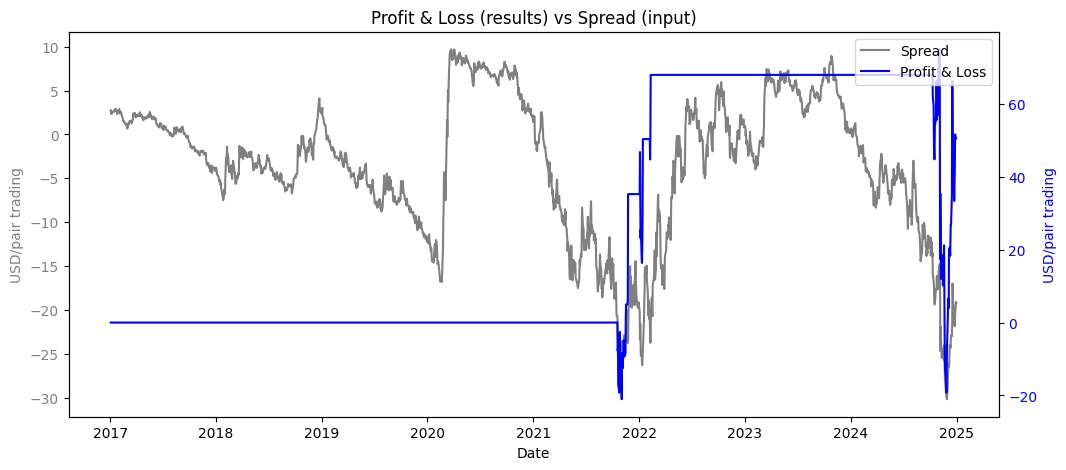

In [8]:
from plots.traditional import compare_trends_plot

compare_trends_plot(test_spread, cumulative_returns)

## 5.2) **Drawdown for PnL and Buy & Hold:**

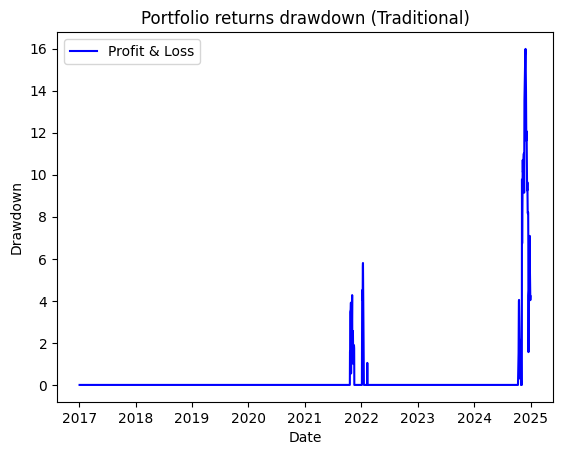

In [9]:
from plots.traditional import drawdown_plot

drawdown_plot(returns)

##**Step 6:** Backtest the strategy for z-score pairs trading and calculate performance metrics on out of sample data

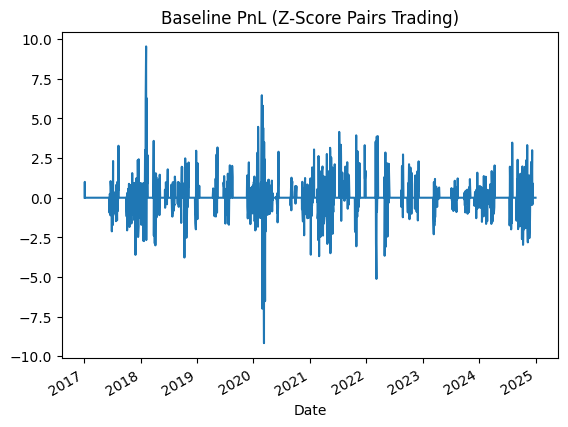

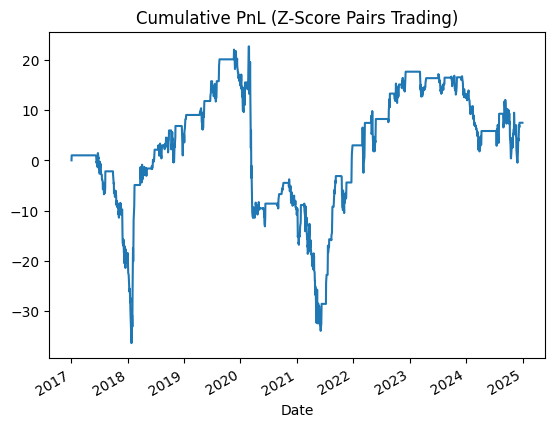

In [10]:
from trad_arbt_strat.zscore_trading import zscore_trading

cumpnl_zscored, rewards_zscored, _ = zscore_trading(test_spread)

In [11]:
# Calculate and print performance metrics
print("Test metrics for Traditional z-score pairs trading:")
print(f"Cummulative profit and loss                       : {cumpnl_zscored[-1]:.6f}")
print(f"Sharpe Ratio                                      : {sharpe_ratio(rewards_zscored):.6f}")
print(f"Sortino ratio                                     : {sortino_ratio(rewards_zscored):.6f}")
print(f"Max drawdown                                      : {compute_max_drawdown(cumpnl_zscored):.6f}")
print(f"Annual Volatility                                 : {annual_volatility(rewards_zscored):.6f}")
alpha_ff, beta_ff = alpha_beta(rewards_zscored[:-1], ff_benchmark_returns)
print(f"Factor-adjusted Alpha-Beta                        : alpha = {alpha_ff:.6f} , beta = {beta_ff:.6f}")
alpha_spy, beta_spy = alpha_beta(rewards_zscored[:-1], test_spy_returns)
print(f"CAPM Alpha-Beta                                   : alpha = {alpha_spy:.6f} , beta = {beta_spy:.6f}")

Test metrics for Traditional z-score pairs trading:
Cummulative profit and loss                       : 7.495391
Sharpe Ratio                                      : 0.059099
Sortino ratio                                     : 0.059451
Max drawdown                                      : 26.137348
Annual Volatility                                 : 15.884893
Factor-adjusted Alpha-Beta                        : alpha = -0.388581 , beta = 9.921656
CAPM Alpha-Beta                                   : alpha = -0.714522 , beta = 10.682048
